In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install tensorflow==2.2.0-rc1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, BatchNormalization, Activation, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import BinaryAccuracy
from PIL import Image

from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import notebook

### Đọc dữ liệu

In [ ]:
im_height = 256
im_width = 256

In [ ]:
import os
ids = next(os.walk("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image"))[2] # list of names all images in the given path
print("Số lượng ảnh = ", len(ids))

Số lượng ảnh =  90


In [ ]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
    # Load images
    img = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/image/"+id_).convert('L'))
    x_img = resize(img, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = np.array(Image.open("/content/drive/MyDrive/KLTN/data_unet/train_isbi/label/"+id_).convert('L'))
    x_mask = resize(mask, (im_height, im_width, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = x_mask/255.0

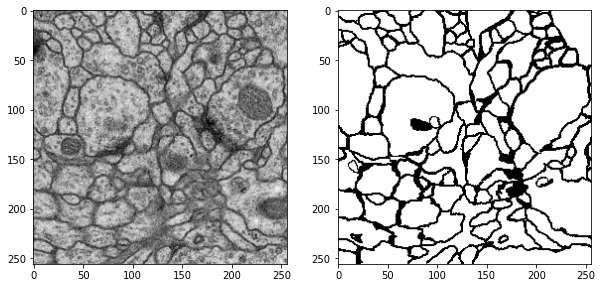

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(X[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.imshow(y[0].squeeze(), cmap = 'gray', interpolation = 'bilinear')

In [ ]:
# chia dữ liệu thành 2 phần 80-20
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print("X train: ", len(X_train))
print("y train: ", len(y_train))
print("X valid: ", len(X_valid))
print(X_train[1].shape)
print(y_train[1].shape)
print(type(X_train[0][0][0][0]))

X train:  72
y train:  72
X valid:  18
(256, 256, 1)
(256, 256, 1)
<class 'numpy.float32'>


### Định nghĩa khối convolution và Conv2DTranspose tùy chỉnh

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
  x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
  x = BatchNormalization(axis=3, scale=False)(x)

  if(activation == None):
    return x

  x = Activation(activation, name=name)(x)
  return x

def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
  x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
  x = BatchNormalization(axis=3, scale=False)(x) 
  return x

### Định nghĩa khối Dual channel và ResPath

In [ ]:
def DCBlock(U, inp, alpha = 1.67):
  W = alpha * U

  conv3x3_1 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
  conv5x5_1 = conv2d_bn(conv3x3_1, int(W*0.333), 3, 3, activation='relu', padding='same')
  conv7x7_1 = conv2d_bn(conv5x5_1, int(W*0.5), 3, 3, activation='relu', padding='same')
  out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1], axis=3)
  out1 = BatchNormalization(axis=3)(out1)
    
  conv3x3_2 = conv2d_bn(inp, int(W*0.167), 3, 3, activation='relu', padding='same')
  conv5x5_2 = conv2d_bn(conv3x3_2, int(W*0.333), 3, 3, activation='relu', padding='same')
  conv7x7_2 = conv2d_bn(conv5x5_2, int(W*0.5), 3, 3, activation='relu', padding='same')
  out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2], axis=3)
  out2 = BatchNormalization(axis=3)(out2)

  out = add([out1, out2])
  out = Activation('relu')(out)
  out = BatchNormalization(axis=3)(out)

  return out

def ResPath(filters, length, inp):
  shortcut = inp
  shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')
  out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

  out = add([shortcut, out])
  out = Activation('relu')(out)
  out = BatchNormalization(axis=3)(out)

  for i in range(length-1):
    shortcut = out
    shortcut = conv2d_bn(shortcut, filters, 1, 1, activation=None, padding='same')
    out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')
    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)
  return out

### Định nghĩa mô hình mạng DC-Unet

In [ ]:
def DCUNet(height, width, channels):
  inputs = Input((height, width, channels))

  dcblock1 = DCBlock(32, inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(dcblock1)
  dcblock1 = ResPath(32, 4, dcblock1)

  dcblock2 = DCBlock(32*2, pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(dcblock2)
  dcblock2 = ResPath(32*2, 3, dcblock2)

  dcblock3 = DCBlock(32*4, pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(dcblock3)
  dcblock3 = ResPath(32*4, 2, dcblock3)

  dcblock4 = DCBlock(32*8, pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(dcblock4)
  dcblock4 = ResPath(32*8, 1, dcblock4)

  dcblock5 = DCBlock(32*16, pool4)

  up6 = concatenate([Conv2DTranspose(32*8, (2, 2), strides=(2, 2), padding='same')(dcblock5), dcblock4], axis=3)
  dcblock6 = DCBlock(32*8, up6)

  up7 = concatenate([Conv2DTranspose(32*4, (2, 2), strides=(2, 2), padding='same')(dcblock6), dcblock3], axis=3)
  dcblock7 = DCBlock(32*4, up7)

  up8 = concatenate([Conv2DTranspose(32*2, (2, 2), strides=(2, 2), padding='same')(dcblock7), dcblock2], axis=3)
  dcblock8 = DCBlock(32*2, up8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(dcblock8), dcblock1], axis=3)
  dcblock9 = DCBlock(32, up9)

  conv10 = conv2d_bn(dcblock9, 1, 1, 1, activation='sigmoid')
    
  model = Model(inputs=[inputs], outputs=[conv10])
    
  return model

In [ ]:
# test new optimizer function
!pip install adabelief-tf==0.2.0
from adabelief_tf import AdaBeliefOptimizer

In [ ]:
model = DCUNet(im_height, im_width, 1)
# model.compile(optimizer=Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer = AdaBeliefOptimizer(learning_rate=0.001, epsilon=1e-12, rectify=False, print_change_log = False), loss="binary_crossentropy", metrics=[BinaryAccuracy()])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 8)  72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  24          conv2d[0][0]                     
______________________________________________________________________________________________

### Đào tạo mô hình

In [ ]:
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/KLTN/model_save/model_DC_Unet_isbi.h5', monitor='val_binary_accuracy', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=12, epochs=250, callbacks=callbacks, validation_data=(X_valid, y_valid))

Epoch 1/250
6/6 [==============================] - 50s 3s/step - loss: 0.4595 - binary_accuracy: 0.7757 - val_loss: 0.5930 - val_binary_accuracy: 0.6943

Epoch 00001: val_binary_accuracy did not improve from 0.69426
Epoch 2/250
6/6 [==============================] - 12s 2s/step - loss: 0.4507 - binary_accuracy: 0.7820 - val_loss: 0.5926 - val_binary_accuracy: 0.6943

Epoch 00002: val_binary_accuracy did not improve from 0.69426
Epoch 3/250
6/6 [==============================] - 12s 2s/step - loss: 0.4403 - binary_accuracy: 0.7899 - val_loss: 0.5886 - val_binary_accuracy: 0.6943

Epoch 00003: val_binary_accuracy did not improve from 0.69426
Epoch 4/250
6/6 [==============================] - 12s 2s/step - loss: 0.4305 - binary_accuracy: 0.7939 - val_loss: 0.5862 - val_binary_accuracy: 0.6943

Epoch 00004: val_binary_accuracy did not improve from 0.69426
Epoch 5/250
6/6 [==============================] - 12s 2s/step - loss: 0.4210 - binary_accuracy: 0.7989 - val_loss: 0.5851 - val_binary_

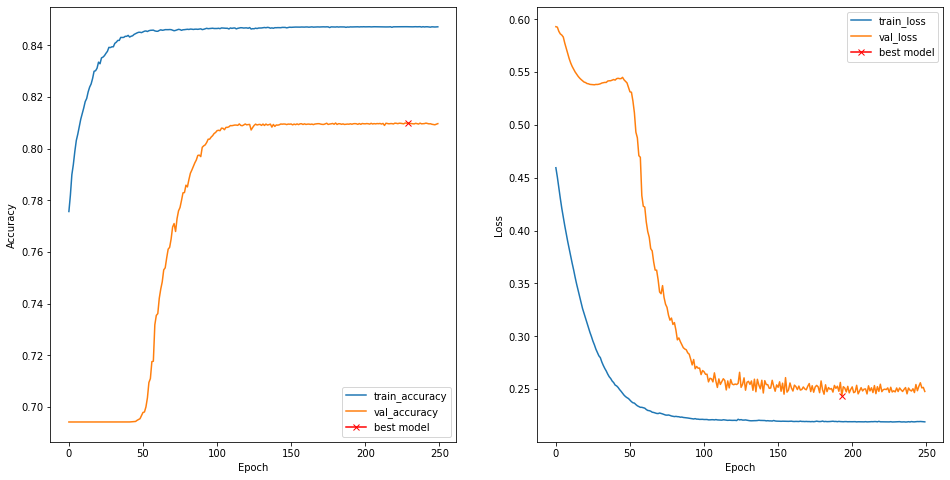

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(1,2,1)
plt.plot(results.history['binary_accuracy'], label='train_accuracy')
plt.plot(results.history['val_binary_accuracy'], label = 'val_accuracy')
plt.plot(np.argmax(results.history["val_binary_accuracy"]), np.max(results.history["val_binary_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(1,2,2)
plt.plot(results.history['loss'], label='train_loss')
plt.plot(results.history['val_loss'], label = 'val_loss')
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [ ]:
# weight tốt nhất
model.load_weights('/content/drive/MyDrive/KLTN/model_save/model_DC_Unet_isbi.h5')

# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/KLTN/model_save/model_salf.h5', compile=False)

In [ ]:
# Độ chính xác trên tập valid
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 37s 37s/step - loss: 0.2474 - binary_accuracy: 0.8099


[0.24738577008247375, 0.8099475502967834]

### Thử nghiệm mô hình

1/1 [==============================] - 0s 382ms/step


Text(0.5, 1.0, 'predict binary')

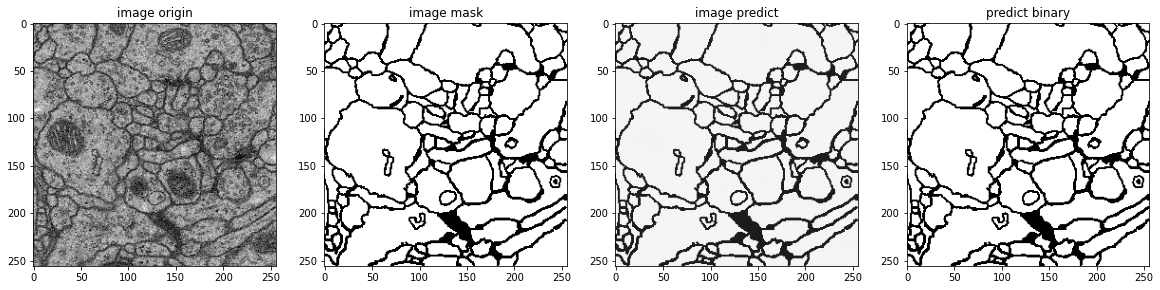

In [ ]:
import random
idx_rd = random.randint(0, len(X_valid)-1)

pred_img = model.predict(X_valid, verbose=1)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))

ax[0].imshow(X_valid[idx_rd].squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(y_valid[idx_rd].squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img[idx_rd].squeeze(), cmap='gray')
ax[2].set_title('image predict')

pred_bn = (pred_img[idx_rd] > 0.5).astype(np.uint8)

ax[3].imshow(pred_bn.squeeze(), cmap='gray')
ax[3].set_title('predict binary')

1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'predict binary')

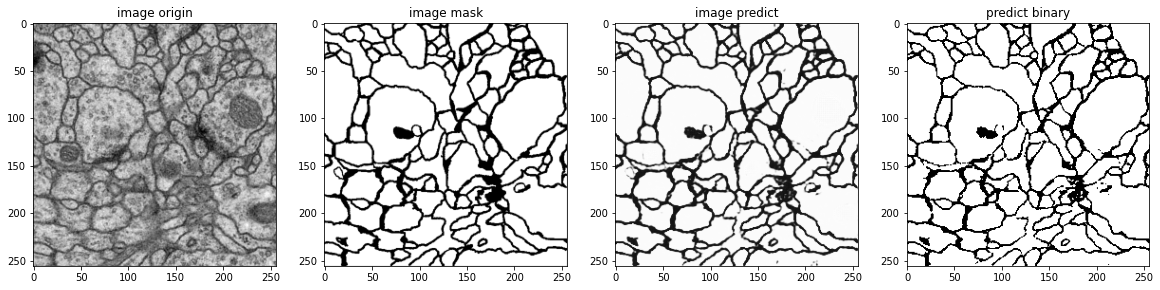

In [ ]:
img_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-volume.tif').convert('L'))
img_test = resize(img_test, (256, 256, 1), mode = 'constant', preserve_range = True)

mask_test = np.array(Image.open('/content/drive/MyDrive/KLTN/data_unet/train_isbi/train-labels.tif').convert('L'))
mask_test = resize(mask_test, (256, 256, 1), mode = 'constant', preserve_range = True)

arr_img = [img_test]
arr_img = np.array(arr_img)/255

# predict
pred_img_test = model.predict(arr_img, verbose=1)

fig, ax = plt.subplots(1, 4, figsize=(20, 10))
ax[0].imshow(img_test.squeeze(), cmap='gray')
ax[0].set_title('image origin')

ax[1].imshow(mask_test.squeeze(), cmap='gray')
ax[1].set_title('image mask')

ax[2].imshow(pred_img_test[0].squeeze(), cmap='gray')
ax[2].set_title('image predict')

pred_bn_test = (pred_img_test[0] > 0.5).astype(np.uint8)
ax[3].imshow(pred_bn_test.squeeze(), cmap='gray')
ax[3].set_title('predict binary')